# Importance sampling with feedforward neural networks


In [1]:
import sys
import time

import pandas as pd

import numpy as np
from numpy import savetxt, loadtxt

import matplotlib.pyplot as plt

from scipy import integrate
from scipy.stats import norm, random_correlation

from tqdm.notebook import trange
from cycler import cycler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers, regularizers
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Subtract, Multiply, Concatenate, Dot
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

np.random.seed(2023)
tf.random.set_seed(2023)


2023-06-02 14:07:10.646090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python version:  3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]
Tensorflow version:  2.10.0
Keras version:  2.10.0


In [2]:
N_train = 100        # Number of time steps for training
N_test = 100         # Number of time steps for testing

################################################################################
##### Further model parameters

T = 1                 # Terminal time
N_assets = 100        # Number of assets

################################################################################

n_hidden = 1          # Number of hidden layers for deep neural network
n_nodes = N_assets    # Number of nodes in hidden layers
batchsize = 1024      # Batch size
learningrate = 1.0e-3 # Learning rate for Adam (standard 1e-3)

N_NN_train = int(2 * 100 * batchsize)     # Size of training data set for neural network
N_NN_test = int(1.0e5)                # Size of testing data set for neural network

################################################################################

delta_t_train = T/N_train         # Time increments for training
delta_t_test = T/N_test           # Time increments for testing

t_train = np.linspace(0, T, N_train+1)
t_test = np.linspace(0, T, N_test+1)


In [3]:
########################################
########## Generating vector of Eigenvalues that sums up to N_assets
y = np.random.uniform(0, 1, (N_assets))
y = y / np.sum(y) * N_assets

########## GENERATING CORRELATION MATRIX AFTER DAVIES & HIGHAM (2000)
rng = np.random.default_rng()
Rho = random_correlation.rvs(y, random_state=rng)

print(np.all(np.linalg.eigvals(Rho) >= 0))

########## GENERATING VARIANCE-COVARIANCE MATRIX
sigma = np.random.uniform(0.1, 0.3, (N_assets))
Sigma = np.empty((N_assets, N_assets))
for i in range(N_assets):
    for j in range(N_assets):
        Sigma[i, j] = sigma[i] * sigma[j] * Rho[i,j]

print(np.all(np.linalg.eigvals(Sigma) >= 0))

########## DECOMPOSING THE VARIANCE-COVARIANCE MATRIX
L = np.linalg.cholesky(Sigma)

X0 = np.random.uniform(10, 200, (N_assets))
mu = np.random.uniform(0.01, 0.09, (N_assets))

weights = np.divide(mu, np.diag(Sigma))
weights = weights / np.sum(weights)

True
True


## Plotting sample path

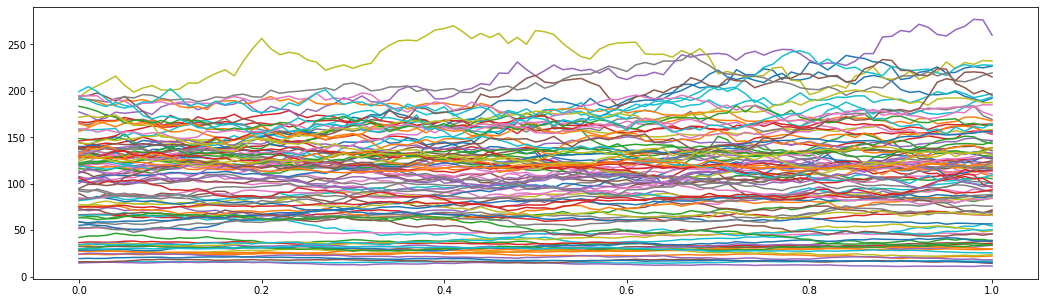

In [4]:
X = np.empty((N_assets, N_test+1))
X[:, 0] = X0

for i in range(N_test):
    increment = np.dot(L, np.random.normal(0, np.sqrt(delta_t_test), (N_assets)))
    
    drift = np.multiply(mu, X[:, i]) * delta_t_test
    diffusion = np.multiply(X[:, i], increment)
    
    X[:, i+1] = X[:, i] + drift + diffusion

plt.figure(figsize=(18, 5))
plt.plot(t_test, np.transpose(X))
plt.show()


Min: 99.779
Mean: 103.6362
90th percentile: 105.36
95th percentile: 105.81
99th percentile: 106.67
Max: 107.264
Payoffs above strike (%): 99.8


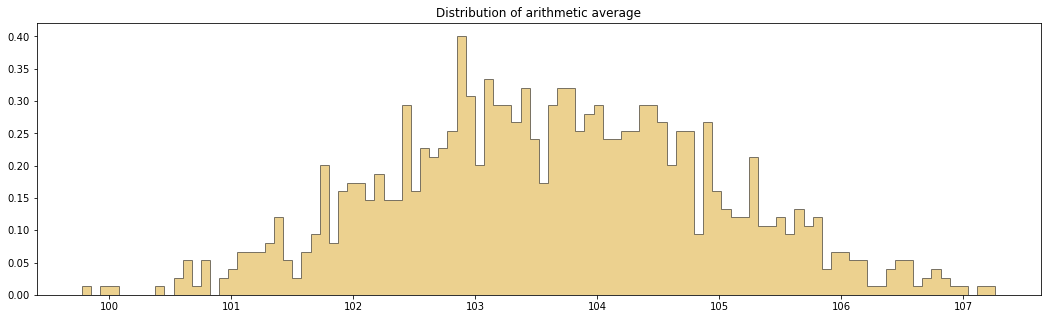

In [5]:
strike = 100

N_sim = 1000

X_ArAv = []

for j in range(N_sim):
    
    X = np.empty((N_assets, N_test+1))
    X[:, 0] = X0
    Y = 0

    for i in range(N_test):
        
        Y += np.dot(weights, X[:, i]) * delta_t_test
        
        increment = np.dot(L, np.random.normal(0, np.sqrt(delta_t_test), (N_assets)))
    
        drift = np.multiply(mu, X[:, i]) * delta_t_test
        diffusion = np.multiply(X[:, i], increment)
    
        X[:, i+1] = X[:, i] + drift + diffusion
    
    X_ArAv += [Y]

print("Min: " + str(np.around(np.min(X_ArAv), 4)))
print("Mean: " + str(np.around(np.mean(X_ArAv), 4)))
print("90th percentile: " + str(np.around(np.quantile(X_ArAv, 0.90), 2)))
print("95th percentile: " + str(np.around(np.quantile(X_ArAv, 0.95), 2)))
print("99th percentile: " + str(np.around(np.quantile(X_ArAv, 0.99), 2)))
print("Max: " + str(np.around(np.max(X_ArAv), 4)))

print("========================================")

print("Payoffs above strike (%): " + str(np.around(np.sum(np.array(X_ArAv) > strike) / N_sim * 100, 2)))
    
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True) # bins='auto'

plt.figure(figsize=(18, 5))

plt.hist(X_ArAv, 
         **kwargs, 
         color='goldenrod', 
         histtype='stepfilled',
         edgecolor='black')

plt.gca().set(title='Distribution of arithmetic average')

plt.show()


In [6]:
counter = 0

for i in range(1000):
    if X_ArAv[i] > 107:
        counter += 1
        
print(counter / 1000 * 100)

0.3


In [7]:
strike = 107     # Strike for the call option

## Input data for NN training

In [8]:
xtrain = ([np.zeros((N_NN_train))] + # t_0
          [np.tile(X0, (N_NN_train, 1))] + # X_0
          [np.tile(mu, (N_NN_train, 1))] + # mu
          [np.tile(weights / T, (N_NN_train, 1))] + # basket weights
          [np.zeros((N_NN_train, N_assets))] + # initial value of the payoff
          [np.zeros((N_NN_train, N_assets))] + # initial value of the first part of the stoch exp
          [np.zeros((N_NN_train))] + # initial value of the second part of the stoch exp
          [np.random.normal(0, np.sqrt(delta_t_train), (N_NN_train, N_assets)) for i in range(N_train)]) # increments N(0,1)

ytrain = np.zeros((N_NN_train))

## Generating neural network

In [9]:
layers = []

layers += [Dense(n_nodes, activation='tanh', trainable=True, input_shape=(1, ))]

for i in range(n_hidden-1):
    layers += [Dense(n_nodes, activation='tanh', trainable=True)]

layers += [Dense(N_assets, activation='linear', trainable=True)]


In [10]:
t_0 = Input(shape=(1, ))
X_0 = Input(shape=(N_assets, ))

drft = Input(shape=(N_assets, ))
wght = Input(shape=(N_assets, ))

c_0 = Input(shape=(N_assets, ))
c_1 = Input(shape=(N_assets, ))
c_2 = Input(shape=(1, ))

inputs = [t_0]+[X_0]+[drft]+[wght]+[c_0]+[c_1]+[c_2]

t_current = t_0
X_current = X_0

for j in range(N_train):
    
    helper_b = Multiply()([wght, X_current]) * delta_t_train
    c_0 = Add()([c_0, helper_b])
    
    strategy = t_current
    for i in range(n_hidden+1):
        strategy = layers[i](strategy)
    
    incr_B = Input(shape=(N_assets, ))
    inputs = inputs + [incr_B]
    
    incr_M = incr_B @ tf.linalg.matrix_transpose(K.constant(L))
    
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = strategy @ tf.linalg.matrix_transpose(K.constant(Sigma))
    helper_e3 = Dot(axes=1)([strategy, helper_e2]) * delta_t_train
    c_2 = Add()([c_2, helper_e3])
    
    t_current = t_current + delta_t_train
    
    helper_x1 = Multiply()([drft, X_current]) * delta_t_train
    helper_x2 = Multiply()([X_current, incr_M])
    helper_x3 = Add()([helper_x1, helper_x2])
    X_current = Add()([X_current, helper_x3])
    
helper_y1 = -0.5 * Lambda(lambda x: K.sum(x, axis=1))(c_1)
helper_y2 = 0.25 * c_2
helper_y3 = Add()([helper_y1, helper_y2])
helper_y4 = Lambda(lambda x: K.exp(x))(helper_y3)

c_0 = Lambda(lambda x: K.sum(x, axis=1))(c_0)
payoff = Lambda(lambda x: 100*K.relu(x-strike))(c_0)
payoff_adjusted = Multiply()([payoff, helper_y4])
 
outputs = [payoff_adjusted]
    

2023-06-02 14:08:52.282266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
opt = optimizers.Adam(learning_rate = learningrate)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=opt, loss='mean_squared_error')


In [12]:
indices_list = []

for i in range(len(model.layers)):
    layer_train_size = len(model.layers[i].get_weights())
    if layer_train_size > 0:
        indices_list += [i]

## Training the neural network

In [13]:
stopping_rule = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=1, 
                              restore_best_weights=True)

In [14]:
start_time = time.time()

history = model.fit(x=xtrain,
                    y=ytrain,
                    epochs=1000,
                    verbose=1,
                    shuffle=True,
                    batch_size=batchsize,
                    validation_split=0.5,
                    callbacks=[stopping_rule])

elapsed_time = time.time() - start_time


Epoch 1/1000
100/100 [==============================] - 131s 1s/step - loss: 18.2896 - val_loss: 11.8077
Epoch 2/1000
100/100 [==============================] - 57s 565ms/step - loss: 7.4346 - val_loss: 6.7037
Epoch 3/1000
100/100 [==============================] - 46s 453ms/step - loss: 4.4939 - val_loss: 4.7853
Epoch 4/1000
100/100 [==============================] - 43s 428ms/step - loss: 3.3041 - val_loss: 3.7463
Epoch 5/1000
100/100 [==============================] - 37s 370ms/step - loss: 2.5826 - val_loss: 2.9937
Epoch 6/1000
100/100 [==============================] - 36s 361ms/step - loss: 2.0974 - val_loss: 2.4432
Epoch 7/1000
100/100 [==============================] - 34s 344ms/step - loss: 1.7294 - val_loss: 2.0293
Epoch 8/1000
100/100 [==============================] - 35s 347ms/step - loss: 1.4514 - val_loss: 1.7040
Epoch 9/1000
100/100 [==============================] - 32s 318ms/step - loss: 1.2313 - val_loss: 1.4455
Epoch 10/1000
100/100 [==============================] 

In [15]:
model_best = keras.Sequential()
model_best.add(Dense(n_nodes, activation='tanh', input_shape=(1, )))

for i in range(n_hidden-1):
    model_best.add(Dense(n_nodes, activation='tanh'))

model_best.add(Dense(N_assets, activation='linear'))
model_best.build()

count = 0
for j in indices_list:
    model_best.layers[count].set_weights(model.layers[j].get_weights())
    count += 1

## Some visualizations

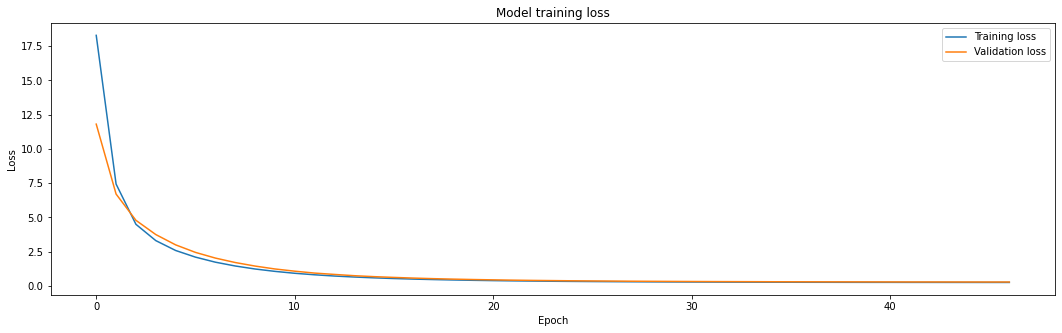

In [16]:
plt.figure(figsize=(18, 5))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.yscale('log')

plt.show()

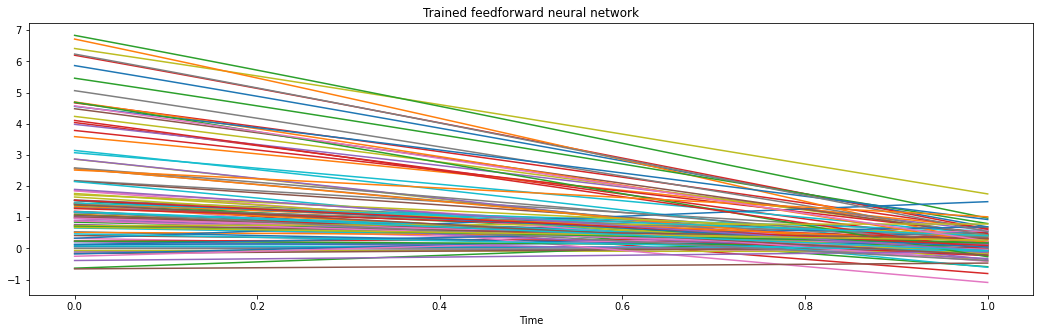

In [17]:
learnedstrat = model_best.predict(t_test, verbose = 0)

plt.figure(figsize=(18, 5))
plt.plot(t_test, learnedstrat)
plt.title("Trained feedforward neural network")
plt.xlabel("Time")
plt.show()


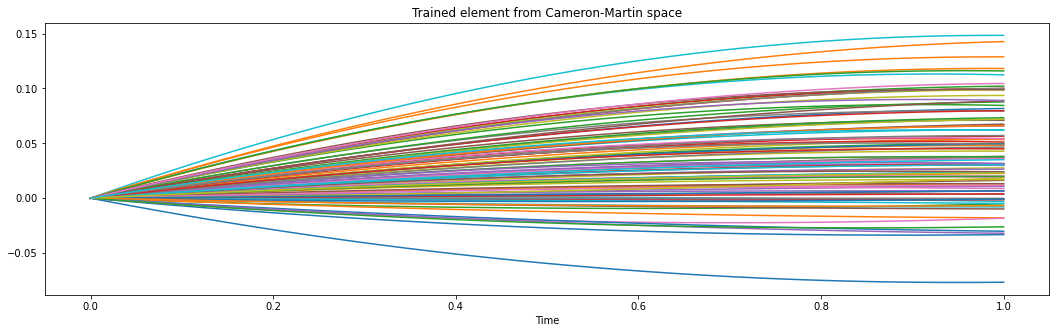

In [18]:
normdrift = 0
driftdummy = np.zeros((N_assets))
drift = np.zeros((N_assets, N_test+1))
driftdelta = np.zeros((N_assets, N_test))

for j in range(N_test):
    normdrift += np.dot(np.transpose(learnedstrat[j,:]), np.dot(Sigma, learnedstrat[j,:])) * delta_t_test
    driftdelta[:, j] = np.dot(Sigma, learnedstrat[j,:]) * delta_t_test
    driftdummy += np.dot(Sigma, learnedstrat[j,:]) * delta_t_test
    drift[:, j+1] = driftdummy

plt.figure(figsize=(18, 5))

plt.plot(t_test, np.transpose(drift))
plt.title("Trained element from Cameron-Martin space")
plt.xlabel("Time")
plt.show()


## Computing option prices

In [19]:
start_time = time.time()

N_sample = 100000

payoffs_MC = []
payoffs_IS = []

counter_MC = 0
counter_IS = 0

for j in range(N_sample):
    
    X_MC = np.empty((N_assets, N_test+1))
    X_IS = np.empty((N_assets, N_test+1))
    
    X_MC[:, 0] = X0
    X_IS[:, 0] = X0
    
    C0 = 0
    
    for i in range(N_test):
        
        increment = np.dot(L, np.random.normal(0, np.sqrt(delta_t_test), (N_assets)))
        
        ########## MC
        
        drift = np.multiply(mu, X_MC[:, i]) * delta_t_test
        diffusion = np.multiply(X_MC[:, i], increment)
    
        X_MC[:, i+1] = X_MC[:, i] + drift + diffusion
        
        ########## IS

        increment_IS = increment + driftdelta[:, i]
    
        drift = np.multiply(mu, X_IS[:, i]) * delta_t_test
        diffusion = np.multiply(X_IS[:, i], increment_IS)
    
        X_IS[:, i+1] =  X_IS[:, i] + drift + diffusion
        
        C0 = C0 - np.dot(learnedstrat[i,:], increment)
        
    #######

    basket_MC = np.sum(np.dot(np.transpose(weights), np.sum(X_MC[:,:N_test], axis=1) * delta_t_test / T))
    payoff_MC = 100*np.clip(basket_MC-strike, 0, None)
    payoffs_MC += [payoff_MC]
    
    if basket_MC > strike:
        
        counter_MC += 1
    
    basket_IS = np.sum(np.dot(np.transpose(weights), np.sum(X_IS[:,:N_test], axis=1) * delta_t_test / T))
    adjustment = np.exp(C0 - 0.5 * normdrift)
    payoff_IS = 100*np.clip(basket_IS-strike, 0, None) * adjustment
    payoffs_IS += [payoff_IS]

    if basket_IS > strike:
        counter_IS += 1

elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


total elapsed time:  00:04:39


In [20]:
mean_MC = np.mean(payoffs_MC)
mean_IS = np.mean(payoffs_IS)

var_MC = np.var(payoffs_MC)
var_IS = np.var(payoffs_IS)

stderr_MC = np.std(payoffs_MC) / np.sqrt(N_sample)
stderr_IS = np.std(payoffs_IS) / np.sqrt(N_sample)

second_moment_MC = np.mean(np.power(payoffs_MC, 2))
second_moment_IS = np.mean(np.power(payoffs_IS, 2))

variance_ratio = np.var(payoffs_MC) / np.var(payoffs_IS)

print("========================================")

print("Mean (MC): ", np.around(mean_MC, 8))
print("Mean (IS): ", np.around(mean_IS, 8))

print("========================================")

print("Variance (MC): ", np.around(var_MC, 8))
print("Variance (IS): ", np.around(var_IS, 8))

print("========================================")

print("Variance ratio: ", np.around(variance_ratio, 4))

print("========================================")

print("Standard error (MC): ", np.around(stderr_MC, 4), " (", np.around(stderr_MC / mean_MC * 100, 2), "% )")
print("Standard error (IS): ", np.around(stderr_IS, 4), " (", np.around(stderr_IS / mean_IS * 100, 2), "% )")

print("========================================")

print("Second moment (MC): ", np.around(second_moment_MC, 4))
print("Second moment (IS): ", np.around(second_moment_IS, 4))

print("========================================")

print("Probability of positive payoff (MC): ", str(np.around(counter_MC / N_sample * 100, 8)))
print("Probability of positive payoff (IS): ", str(np.around(counter_IS / N_sample * 100, 8)))


Mean (MC):  0.3679144
Mean (IS):  0.31967281
Variance (MC):  32.49066283
Variance (IS):  0.18684554
Variance ratio:  173.8905
Standard error (MC):  0.018  ( 4.9 % )
Standard error (IS):  0.0014  ( 0.43 % )
Second moment (MC):  32.626
Second moment (IS):  0.289
Probability of positive payoff (MC):  0.725
Probability of positive payoff (IS):  64.266
